# Spike train extraction and re-ordering

- Extract spike trains from simulation campaign
- Re-arrange spike trains suitable for reliability computations

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.sparse as sps
from bluepy import Cell, Circuit, Simulation

import sys
sys.path.append('../../../reliability_and_structure/library')

## Extract spike trains from toposample simulations using SSCx-Hex0 rewired connectomes

In [2]:
campaign_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/simulations/SSCx-Bio_M-20200805-HexO1_Ca1p2ShotNoise_Hex0Toposample'
# campaign_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/simulations/SSCx-Bio_M-20200805-HexO1_Ca1p2ShotNoise_Hex0Toposample_ConnRewireOrder1Hex0EE100pct'
# campaign_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/simulations/SSCx-Bio_M-20200805-HexO1_Ca1p2ShotNoise_Hex0Toposample_ConnRewireOrder2Hex0EE100pct'
# campaign_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/simulations/SSCx-Bio_M-20200805-HexO1_Ca1p2ShotNoise_Hex0Toposample_ConnRewireOrder3Hex0EE100pct'
# campaign_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/simulations/SSCx-Bio_M-20200805-HexO1_Ca1p2ShotNoise_Hex0Toposample_ConnRewireOrder4Hex0EE100pct'
# campaign_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/simulations/SSCx-Bio_M-20200805-HexO1_Ca1p2ShotNoise_Hex0Toposample_ConnRewireOrder5Hex0EE100pct'


In [3]:
# Load campaign config
with open(os.path.join(campaign_path, 'config.json'), 'r') as f:
    config_dict = json.load(f)
sim_paths = [os.path.join(config_dict['attrs']['path_prefix'], p) for p in config_dict['data']]

# Set up save path (= working dir)
working_dir_name = 'reliability_working_dir_v2'
save_path = os.path.join(config_dict['attrs']['path_prefix'], config_dict['name'], working_dir_name)
if not os.path.exists(save_path): # Create results folder
    os.makedirs(save_path)
    os.symlink(save_path, os.path.join(campaign_path, os.path.split(save_path)[-1])) # Create symbolic link

### __Variant 1:__ Extract and re-arrange spike trains, then preprocess re-arranged spike trains

In [ ]:
from extract import extract_neuron_info, extract_adj_matrix, extract_stim_train

In [4]:
# Get stimulus config
blue_config = os.path.join(sim_paths[0], 'BlueConfig')
sim = Simulation(blue_config)
c = sim.circuit
hex0 = c.cells.ids('hex0')
input_spike_file = os.path.abspath(os.path.join(sim.config['Run_Default']['OutputRoot'], sim.config['Stimulus_spikeReplay']['SpikeFile']))
stim_config_file = os.path.splitext(input_spike_file)[0] + '.json'

In [5]:
# Extract neuron info [same for all sims]
neuron_info = extract_neuron_info(c, hex0, save_path)

/gpfs/bbp.cscs.ch/home/pokorny/BbpWorkflowKernel/lib/python3.9/site-packages/tables/file.py:411: UserWarning: a closed node found in the registry: ``/neuron_info/meta/values_block_3/meta/_i_table``
  warnings.warn("a closed node found in the registry: "


In [6]:
# Extract adjacency matrix [same for all sims]
adj_matrix = extract_adj_matrix(c, neuron_info, save_path)

In [ ]:
# Extract stim train & time windows [assuming a single sim in campaign]
assert len(sim_paths) == 1, 'ERROR: Single simulation in campaign expected!'
stim_train, time_windows = extract_stim_train(stim_config_file, save_path=None)

patterns, pattern_counts = np.unique(stim_train, return_counts=True)
num_patterns = len(patterns)
pattern_counts = np.unique(pattern_counts)
assert len(pattern_counts) == 1, 'ERROR: Equal number of repetitions per pattern expected!'
pattern_counts = pattern_counts[0]
print(f'INFO: Found {num_patterns} patterns with {pattern_counts} repetitions per pattern')

In [8]:
# Re-arrange patterns (order: 0123012301230123, keeping order of occurrence)
num_blocks = 10 # Number of simulation blocks
reps_per_block_per_pattern = pattern_counts / num_blocks
assert reps_per_block_per_pattern == int(reps_per_block_per_pattern), 'ERROR: Integer count required!'
reps_per_block_per_pattern = int(reps_per_block_per_pattern)

idx_per_blocks = []
for p in patterns:
    block_idx = []
    for b in range(num_blocks):
        block_idx.append(np.where(stim_train == p)[0][np.arange(b, pattern_counts, num_blocks)])
    idx_per_blocks.append(block_idx)
idx_per_blocks = np.hstack(np.array(idx_per_blocks).T)

stim_train_per_block = np.squeeze(np.unique(stim_train[idx_per_blocks], axis=0))
assert np.array_equal(stim_train_per_block, np.hstack([np.arange(num_patterns)] * reps_per_block_per_pattern)), 'ERROR: Wrong re-arrangement of patterns!'
assert np.array_equal(np.unique(idx_per_blocks), np.arange(len(stim_train))), 'ERROR: Wrong re-arrangement of patterns!'

print(f'INFO: Pattern re-arrangement for {num_blocks} sim block:\n{stim_train_per_block}')

INFO: Pattern re-arrangement for 10 sim block:
[0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3]


In [9]:
# Extract spike trains according to re-arranged patterns
syn_class = 'EXC'
sim = Simulation(os.path.join(sim_paths[0], 'BlueConfig'))
gids = neuron_info[neuron_info['synapse_class'] == syn_class].index
raw_spikes = sim.spikes.get(gids)
raw_spikes = np.vstack((raw_spikes.index, raw_spikes.to_numpy())).T

time_windows_per_block = None
spike_counts = np.full(num_blocks, -1)
for bidx in range(num_blocks):
    block_spikes = []
    block_offset = 0
    block_time_windows = [block_offset]
    for pidx in range(num_patterns * reps_per_block_per_pattern):
        stim_idx = idx_per_blocks[bidx, pidx]
        cut_start = time_windows[stim_idx]
        cut_end = time_windows[stim_idx + 1]
        spk = raw_spikes[np.logical_and(raw_spikes[:, 0] >= cut_start, raw_spikes[:, 0] < cut_end), :] # Cut spikes
        spk[:, 0] = spk[:, 0] - cut_start + block_offset # Correct spike times
        block_spikes.append(spk)
        block_offset += cut_end - cut_start
        block_time_windows.append(block_offset)

    block_time_windows = np.array(block_time_windows)
    if time_windows_per_block is None:
        time_windows_per_block = block_time_windows
    else:
        assert np.array_equal(time_windows_per_block, block_time_windows), 'ERROR: Block time windows mismatch!'

    # Write spikes to file
    block_spikes = np.vstack(block_spikes)
    np.save(os.path.join(save_path, f'raw_spikes_{syn_class.lower()}_{bidx}.npy'), block_spikes)
    spike_counts[bidx] = block_spikes.shape[0]

# Write new time windows & stim trains to file
np.save(os.path.join(save_path, 'time_windows.npy'), time_windows_per_block)
np.save(os.path.join(save_path, 'stim_stream.npy'), stim_train_per_block)

print(f'INFO: {num_blocks} spike files with {np.mean(spike_counts):.1f} +/- {np.std(spike_counts):.1f} (SD) spikes written to file')

/gpfs/bbp.cscs.ch/ssd/apps/bsd/2022-01-10/stage_applications/install_gcc-11.2.0-skylake/py-numpy-1.19.5-gjm7kk/lib/python3.9/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


INFO: 10 spike files with 778679.4 +/- 39213.3 (SD) spikes written to file


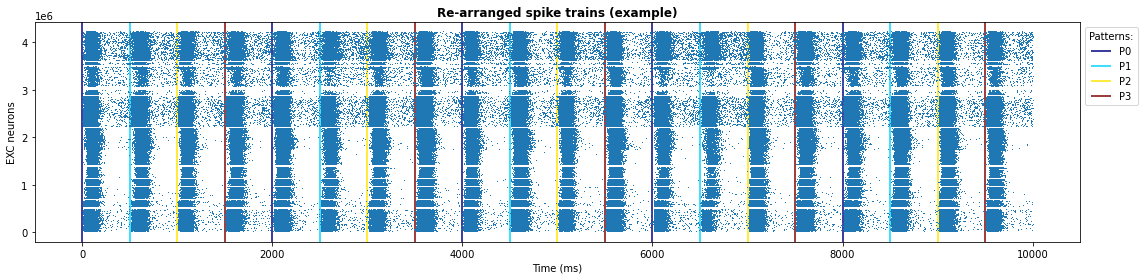

In [10]:
# Plot one example spike block (last one)
pattern_colors = plt.cm.jet(np.linspace(0, 1, num_patterns))

plt.figure(figsize=(16, 4))
plt.plot(block_spikes[:, 0], block_spikes[:, 1], ',')
plt.ylim(plt.ylim())
for pidx in np.arange(num_patterns):
    plt.vlines(time_windows_per_block[:-1][stim_train_per_block == pidx], ymin=np.min(plt.ylim()), ymax=np.max(plt.ylim()), color=pattern_colors[pidx, :], label=f'P{pidx}')
plt.xlabel('Time (ms)')
plt.ylabel(f'{syn_class} neurons')
plt.title(f'Re-arranged spike trains (example)', fontweight='bold')
plt.legend(loc='upper left', bbox_to_anchor=[1.0, 1.0], title='Patterns:')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'spike_train_example.png'), dpi=300)
plt.show()

__To be continued with:__ Step 2 "Compute filtered spike signals & mean-centering" in <code>run_preprocessing_pipeline.ipynb</code>:

In [11]:
print(f'working_dir = "{save_path}"')
print(f'num_sims = {num_blocks}')

working_dir = "/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/43269208-a4e3-4b21-9d25-fa97c23399d9/reliability_working_dir"
num_sims = 10


### __Variant 2:__ Extract full spike trains and preprocess them, then re-arrange filtered spike signals

In [4]:
from extract import run_extraction
from preprocess import run_preprocessing, run_rate_extraction

In [14]:
# Run spike extraction
sim_paths, working_dir = run_extraction(campaign_path, working_dir_name=working_dir_name, cell_target='hex0')
num_sims = len(sim_paths)

INFO: 1 spike files written to "/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/2bc672d4-1f3a-413d-bcff-1a4f6ccd7516/reliability_working_dir_v2"


In [18]:
# Run preprocessing
spike_file_names = [f'raw_spikes_exc_{idx}.npy' for idx in range(num_sims)]
run_preprocessing(working_dir, spike_file_names, sigma=10.0, mean_centered=True, pool_size=10)

Finished preprocessing in 1216.512s


#### Re-arrange spike signals

In [5]:
# working_dir = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/2bc672d4-1f3a-413d-bcff-1a4f6ccd7516/reliability_working_dir_v2'
# spike_file_names = ['raw_spikes_exc_0.npy']
# num_sims = len(spike_file_names)

In [6]:
# Extract stim train & time windows [assuming a single sim in campaign]
stim_train = np.load(os.path.join(working_dir, 'stim_stream.npy'))
time_windows = np.load(os.path.join(working_dir, 'time_windows.npy'))

patterns, pattern_counts = np.unique(stim_train, return_counts=True)
num_patterns = len(patterns)
pattern_counts = np.unique(pattern_counts)
assert len(pattern_counts) == 1, 'ERROR: Equal number of repetitions per pattern expected!'
pattern_counts = pattern_counts[0]
print(f'INFO: Found {num_patterns} patterns with {pattern_counts} repetitions per pattern')

INFO: Found 4 patterns with 50 repetitions per pattern


In [7]:
# Re-arrange patterns (order: 00000111112222233333, randomizing selection of patterns)
meta_seed = 0
num_blocks = 10 # Number of simulation blocks
num_fake_campaigns = 50 # Number of "fake" simulation campaigns with <num_blocks> sims each
reps_per_block_per_pattern = pattern_counts / num_blocks
assert reps_per_block_per_pattern == int(reps_per_block_per_pattern), 'ERROR: Integer count required!'
reps_per_block_per_pattern = int(reps_per_block_per_pattern)

np.random.seed(meta_seed)
campaign_blocks = []
for cpgn_idx in range(num_fake_campaigns):
    idx_per_blocks = []
    for p in patterns:
        p_indices = np.reshape(np.random.permutation(np.where(stim_train == p)[0]), (num_blocks, reps_per_block_per_pattern))
        idx_per_blocks.append(p_indices)
    idx_per_blocks = np.hstack(np.array(idx_per_blocks))

    stim_train_per_block = np.squeeze(np.unique(stim_train[idx_per_blocks], axis=0))
    assert np.array_equal(stim_train_per_block, np.hstack([[i] * reps_per_block_per_pattern for i in range(num_patterns)])), 'ERROR: Wrong re-arrangement of patterns!'
    assert np.array_equal(np.unique(idx_per_blocks), np.arange(len(stim_train))), 'ERROR: Wrong re-arrangement of patterns!'

    campaign_blocks.append(idx_per_blocks)

print(f'INFO: Pattern re-arrangement for {num_blocks} sim block:\n{stim_train_per_block}')

INFO: Pattern re-arrangement for 10 sim block:
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3]


In [ ]:
# Extract spike signals according to re-arranged patterns
signal_file = os.path.join(working_dir, 'spike_signals_exc_0__tmp__.npz')
signal_dict = np.load(signal_file)
spike_signals = signal_dict['spike_signals']
t_bins = signal_dict['t_bins']
gids = signal_dict['gids']
sigma = signal_dict['sigma']
mean_centered = signal_dict['mean_centered']

raw_spikes_file = os.path.join(working_dir, 'raw_spikes_exc_0.npy')
raw_spikes = np.load(raw_spikes_file)

assert t_bins[0] == time_windows[0] and t_bins[-1] == time_windows[-1], 'ERROR: Time axis mismatch!'
assert np.min(np.diff(t_bins)) == 1.0, 'ERROR: Time resolution 1ms expected!' # [So that time onsets can directly be used for indexing!]
T_trial = np.min(np.diff(time_windows))

campaigns_path = os.path.join(working_dir, f'fake_campaigns_choose{num_blocks}_seed{meta_seed}')
if not os.path.exists(campaigns_path):
    os.makedirs(campaigns_path)

time_windows_per_block = np.arange(len(stim_train_per_block) + 1) * T_trial
np.save(os.path.join(campaigns_path, 'time_windows.npy'), time_windows_per_block)
np.save(os.path.join(campaigns_path, 'stim_stream.npy'), stim_train_per_block)

raw_spike_fn = '_'.join(os.path.split(raw_spikes_file)[-1].split('__')[0].split('_')[:-1])
spike_fn = '_'.join(os.path.split(signal_file)[-1].split('__')[0].split('_')[:-1])
print(f'Generating {num_fake_campaigns} fake campaigns:')
for cpgn_idx, idx_per_blocks in enumerate(campaign_blocks):
    print(cpgn_idx + 1, end='')
    cpgn_path = os.path.join(campaigns_path, f'sim_campaign_{cpgn_idx}')
    if os.path.exists(cpgn_path): # [SKIP EXISTING ONES]
        continue
    if not os.path.exists(cpgn_path):
        os.makedirs(cpgn_path)
        # Create symbolic link
        for fn in ['neuron_info.pickle', 'connectivity.npz']:
            os.symlink(os.path.join(working_dir, fn), os.path.join(cpgn_path, fn))
        for fn in ['stim_stream.npy', 'time_windows.npy']:
            os.symlink(os.path.join(campaigns_path, fn), os.path.join(cpgn_path, fn))

    cpgn_spike_fns = []
    for bl_idx, bl_sel in enumerate(idx_per_blocks):
        print('.', end='')

        # Cut spike signals
        t_onsets = time_windows[bl_sel]
        trial_indices = np.hstack([np.arange(t, t + T_trial) for t in t_onsets]).astype(int)
        sp = spike_signals[:, trial_indices].copy() # Re-arranged spike signals [copy() ... IMPORTANT, otherwise saving with compression does not work for some reason!!]
        t = np.arange(sp.shape[1] + 1).astype(float) # New time bins
        np.savez_compressed(os.path.join(cpgn_path, f'{spike_fn}_{bl_idx}__tmp__.npz'), spike_signals=sp, t_bins=t, gids=gids, sigma=sigma, mean_centered=mean_centered)

        # Cut raw spike trains
        block_spikes = []
        block_offset = 0
        block_time_windows = [block_offset]
        block_patt_seq = []
        for stim_idx in bl_sel:
            cut_start = time_windows[stim_idx]
            cut_end = time_windows[stim_idx + 1]
            spk = raw_spikes[np.logical_and(raw_spikes[:, 0] >= cut_start, raw_spikes[:, 0] < cut_end), :] # Cut spikes
            spk[:, 0] = spk[:, 0] - cut_start + block_offset # Correct spike times
            block_spikes.append(spk)
            block_offset += cut_end - cut_start
            block_time_windows.append(block_offset)
            block_patt_seq.append(stim_train[stim_idx])
        block_spikes = np.vstack(block_spikes)
        block_time_windows = np.array(block_time_windows)
        assert np.array_equal(time_windows_per_block, block_time_windows), 'ERROR: Block time windows mismatch!'
        assert np.array_equal(stim_train_per_block, block_patt_seq), 'ERROR: Block pattern sequence mismatch!'

        block_spike_fn = f'{raw_spike_fn}_{bl_idx}.npy'
        np.save(os.path.join(cpgn_path, block_spike_fn), block_spikes)
        cpgn_spike_fns.append(block_spike_fn)

    # Extract firing rates from raw spike trains
    run_rate_extraction(cpgn_path, cpgn_spike_fns, pool_size=len(cpgn_spike_fns))

print(f'\nINFO: Generated {cpgn_idx + 1} "fake" campaigns with {num_blocks} spike files each')